In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from tqdm.notebook import tqdm

from sklearn.manifold import TSNE

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
batch_size = 64

transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

cuda:0


In [ ]:
mnist = MNIST('./mnist_root', train=True, transform=transforms, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]


Extracting ./mnist_root/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_root/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]


Extracting ./mnist_root/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_root/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.38MB/s]


Extracting ./mnist_root/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_root/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.84MB/s]

Extracting ./mnist_root/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_root/MNIST/raw



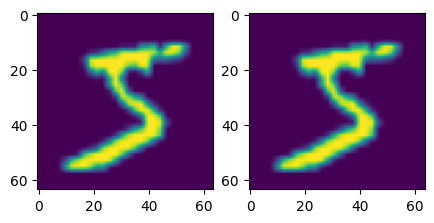

In [ ]:
i = 0
plt.figure(figsize=(5, 8))
for (image, label) in mnist:
  i += 1
  plt.subplot(1, 2, 1)
  plt.imshow(image.squeeze())
  plt.subplot(1, 2, 2)
  plt.imshow((image.squeeze() + 1) / 2)
  break
plt.show()



In [ ]:
class ZeroMNIST(torch.utils.data.Dataset):
  def __init__(self, mnist):
    self.images = []
    for image, label in mnist:
      if label == 0:
        self.images.append(image)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    return self.images[index]

zero_mnist = ZeroMNIST(mnist)
train_dataloader = DataLoader(zero_mnist, batch_size, drop_last=True)


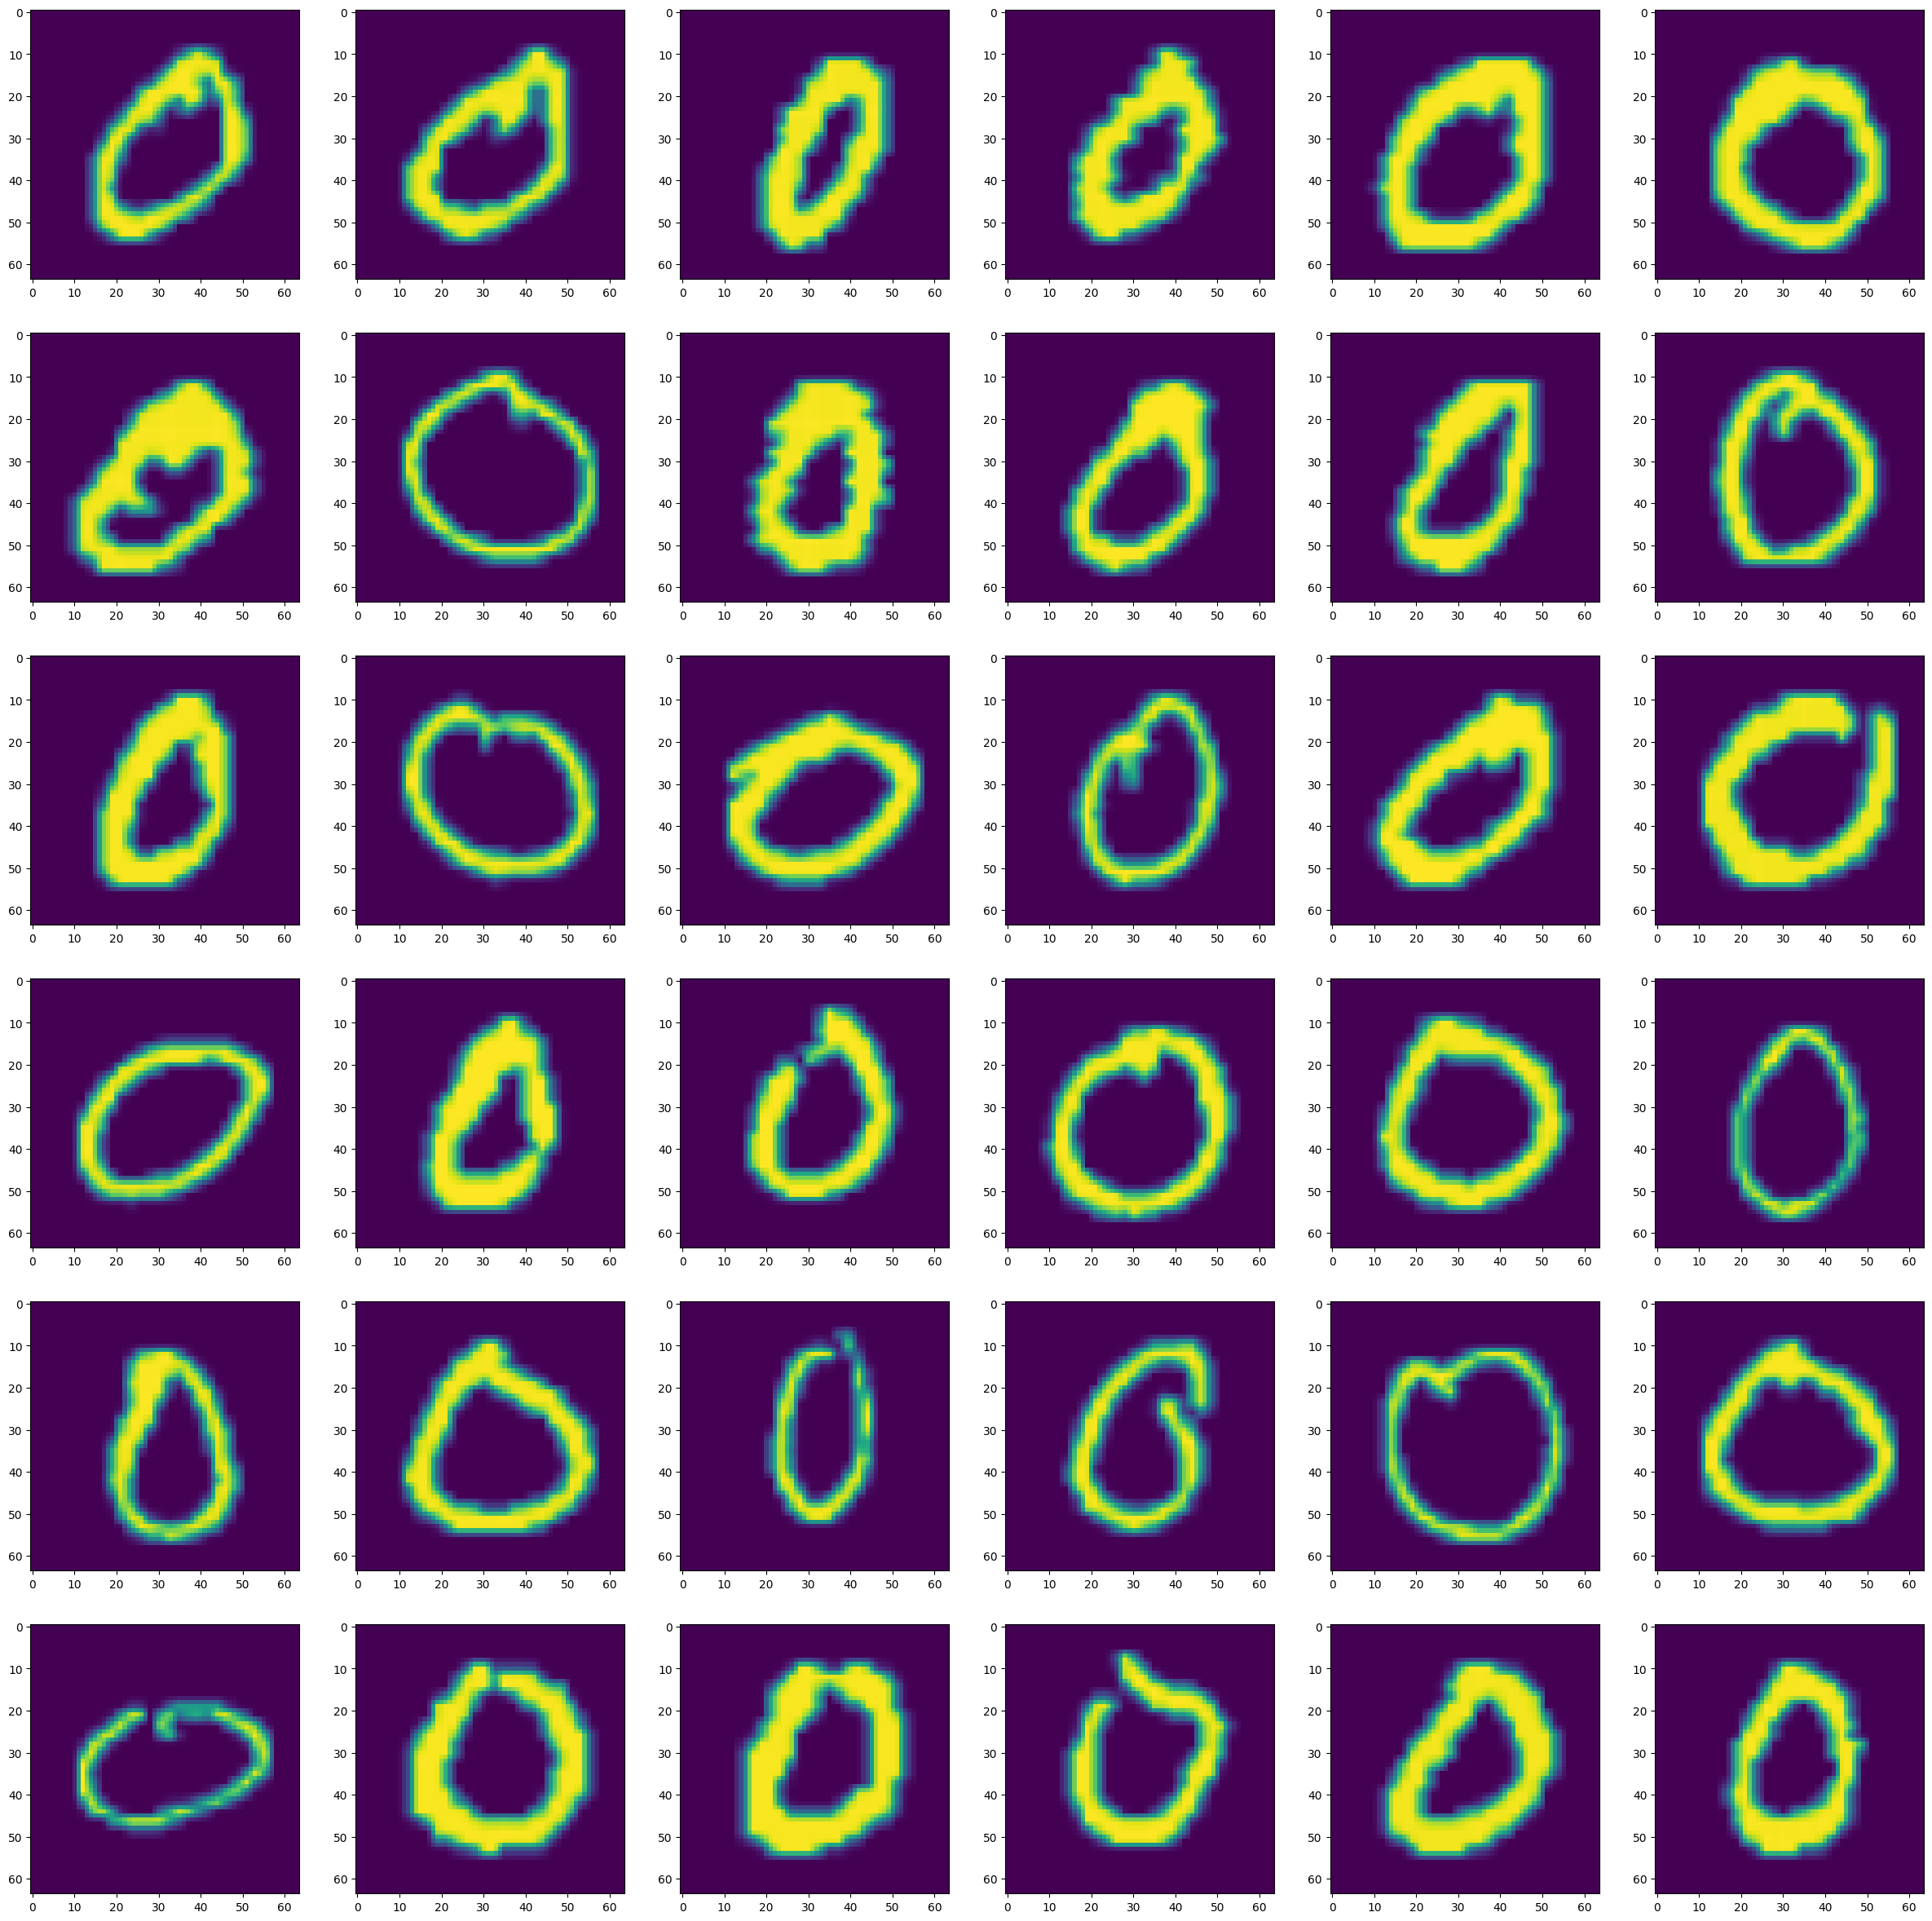

In [ ]:
plt.figure(figsize=(30, 30))
for ind, image in enumerate(zero_mnist):
    if ind >= 6*6: break
    plt.subplot(6, 6, ind+1)
    plt.imshow(((image.squeeze() + 1) / 2))
plt.show()

In [ ]:
zero_mnist[0].shape

torch.Size([1, 64, 64])

In [ ]:
import torch.nn as nn

class Generator(nn.Module):

  def __init__(self, in_dim, dim=64, channels=3):
    super().__init__()

    def dconv_bn_relu_block(in_dim, out_dim):
      return nn.Sequential(
          nn.Upsample(scale_factor=2, mode='bilinear'),
          nn.Conv2d(in_channels=in_dim, out_channels=out_dim, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_dim),
          nn.ReLU()
      )

    self.transform_noise = nn.Sequential(
        nn.Linear(in_dim, dim * 4 * 4 * 4),
        nn.BatchNorm1d(dim * 4 * 4 * 4),
        nn.ReLU()
    )
    self.l = nn.Sequential(
        dconv_bn_relu_block(dim * 4, dim * 2), # dim * 4 x 4 x 4 -> dim * 2 x 8 x 8
        dconv_bn_relu_block(dim * 2,  dim), # dim * 2 x 8 x 8 - > out_dim x 16 x 16
        dconv_bn_relu_block(dim, dim), # dim x 16 x 16 -> dim x 32 x 32
        # dim x 32 x 32 ->  # channels x 64 x 64
        nn.Upsample(scale_factor=2, mode='bilinear'),
        nn.Conv2d(in_channels=dim, out_channels=channels, kernel_size=3, padding=1),
        nn.Tanh()
    )

  def forward(self, x):
    y = self.transform_noise(x)
    y = y.view(y.shape[0], -1, 4, 4)
    y = self.l(y)
    return y



In [ ]:
class Discriminator(nn.Module):
  def __init__(self, dim=64, channels=3):
    super().__init__()

    def conv_inst_lr_block(in_dim, out_dim):
      return nn.Sequential(
          nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1),
          nn.InstanceNorm2d(out_dim),
          nn.LeakyReLU(0.2)
          )

    self.l = nn.Sequential(
        conv_inst_lr_block(channels, dim), # channels x 64 x 64 -> dim x 32 x 32,
        conv_inst_lr_block(dim, dim * 2), # dim x 32 x 32 -> 2 * dim x 16 x 16
        conv_inst_lr_block(dim * 2, dim * 4), # 2 * dim x 16 x 16 -> 4 * dim x 8 x 8
        conv_inst_lr_block(dim * 4, dim * 4), # 4 * dim x 8 x 8 -> 4 * dim x 4 x 4
        nn.Conv2d(dim * 4, 1, kernel_size=4)
    )

  def forward(self, x):
    y = self.l(x)
    y = y.view(-1)
    return y

In [ ]:
z_dim = 100
img_dim = 3

D = Discriminator(channels=1)
G = Generator(z_dim, channels=1)

In [ ]:
z = torch.randn(64, z_dim)

fake_imgs = G(z)

D(fake_imgs).shape

torch.Size([64])

In [ ]:
def compute_gradient_penalty(D, real_images, fake_images):
  """Calculates the gradient penalty loss for WGAN GP"""
  alpha = torch.rand((real_images.size(0), 1, 1, 1), device=device)
  # Get random interpolation between real and fake samples
  interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)
  d_interpolates = D(interpolates)
    # Get gradient w.r.t. interpolates
  gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(real_images.shape[0], requires_grad=False, device=device), # gradients w.t. output. 1 is default
        create_graph=True,
        retain_graph=True, # keep all gradients for further optimization steps
        only_inputs=True,
  )[0]
  gradients = gradients.view(gradients.size(0), -1)
  gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
  return gradient_penalty

# Обучение модели

In [ ]:
NUM_EPOCHS = 50
N_CRITIC = 5
LAMBDA_GP = 10
Z_DIM = 100

def train(G, D, d_optimizer, g_optimizer, dataloader):
    with tqdm(total=NUM_EPOCHS*len(dataloader), desc=f"[D loss: ?] [G loss: ?]") as pbar:
        for epoch in range(NUM_EPOCHS):
            print(epoch)
            for i, imgs in enumerate(dataloader):
                real_imgs = imgs.to(device)
                d_optimizer.zero_grad()

                # sample noise
                z = torch.randn(imgs.shape[0], Z_DIM, device=device)

                fake_imgs = G(z)

                real_valid = D(real_imgs)
                fake_valid = D(fake_imgs)
                gradient_penalty = compute_gradient_penalty(D, real_imgs, fake_imgs)
                d_loss = -torch.mean(real_valid) + torch.mean(fake_valid) + LAMBDA_GP * gradient_penalty
                d_loss.backward()
                d_optimizer.step()

                # every N_CRITIC epochs train the G
                if i % N_CRITIC == 0 :
                    fake_imgs = G(z)
                    fake_valid = D(fake_imgs)

                    g_optimizer.zero_grad()
                    g_loss = -torch.mean(fake_valid)

                    g_loss.backward()
                    g_optimizer.step()

                pbar.set_description(f"[D loss: {d_loss.item():.2f}] [G loss: {g_loss.item():.2f}]")
                pbar.update(1)





In [ ]:
D = Discriminator(channels=1).to(device)
G = Generator(Z_DIM, channels=1).to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
train(G, D, d_optimizer, g_optimizer, train_dataloader)

[D loss: ?] [G loss: ?]:   0%|          | 0/4600 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


**Результаты**:

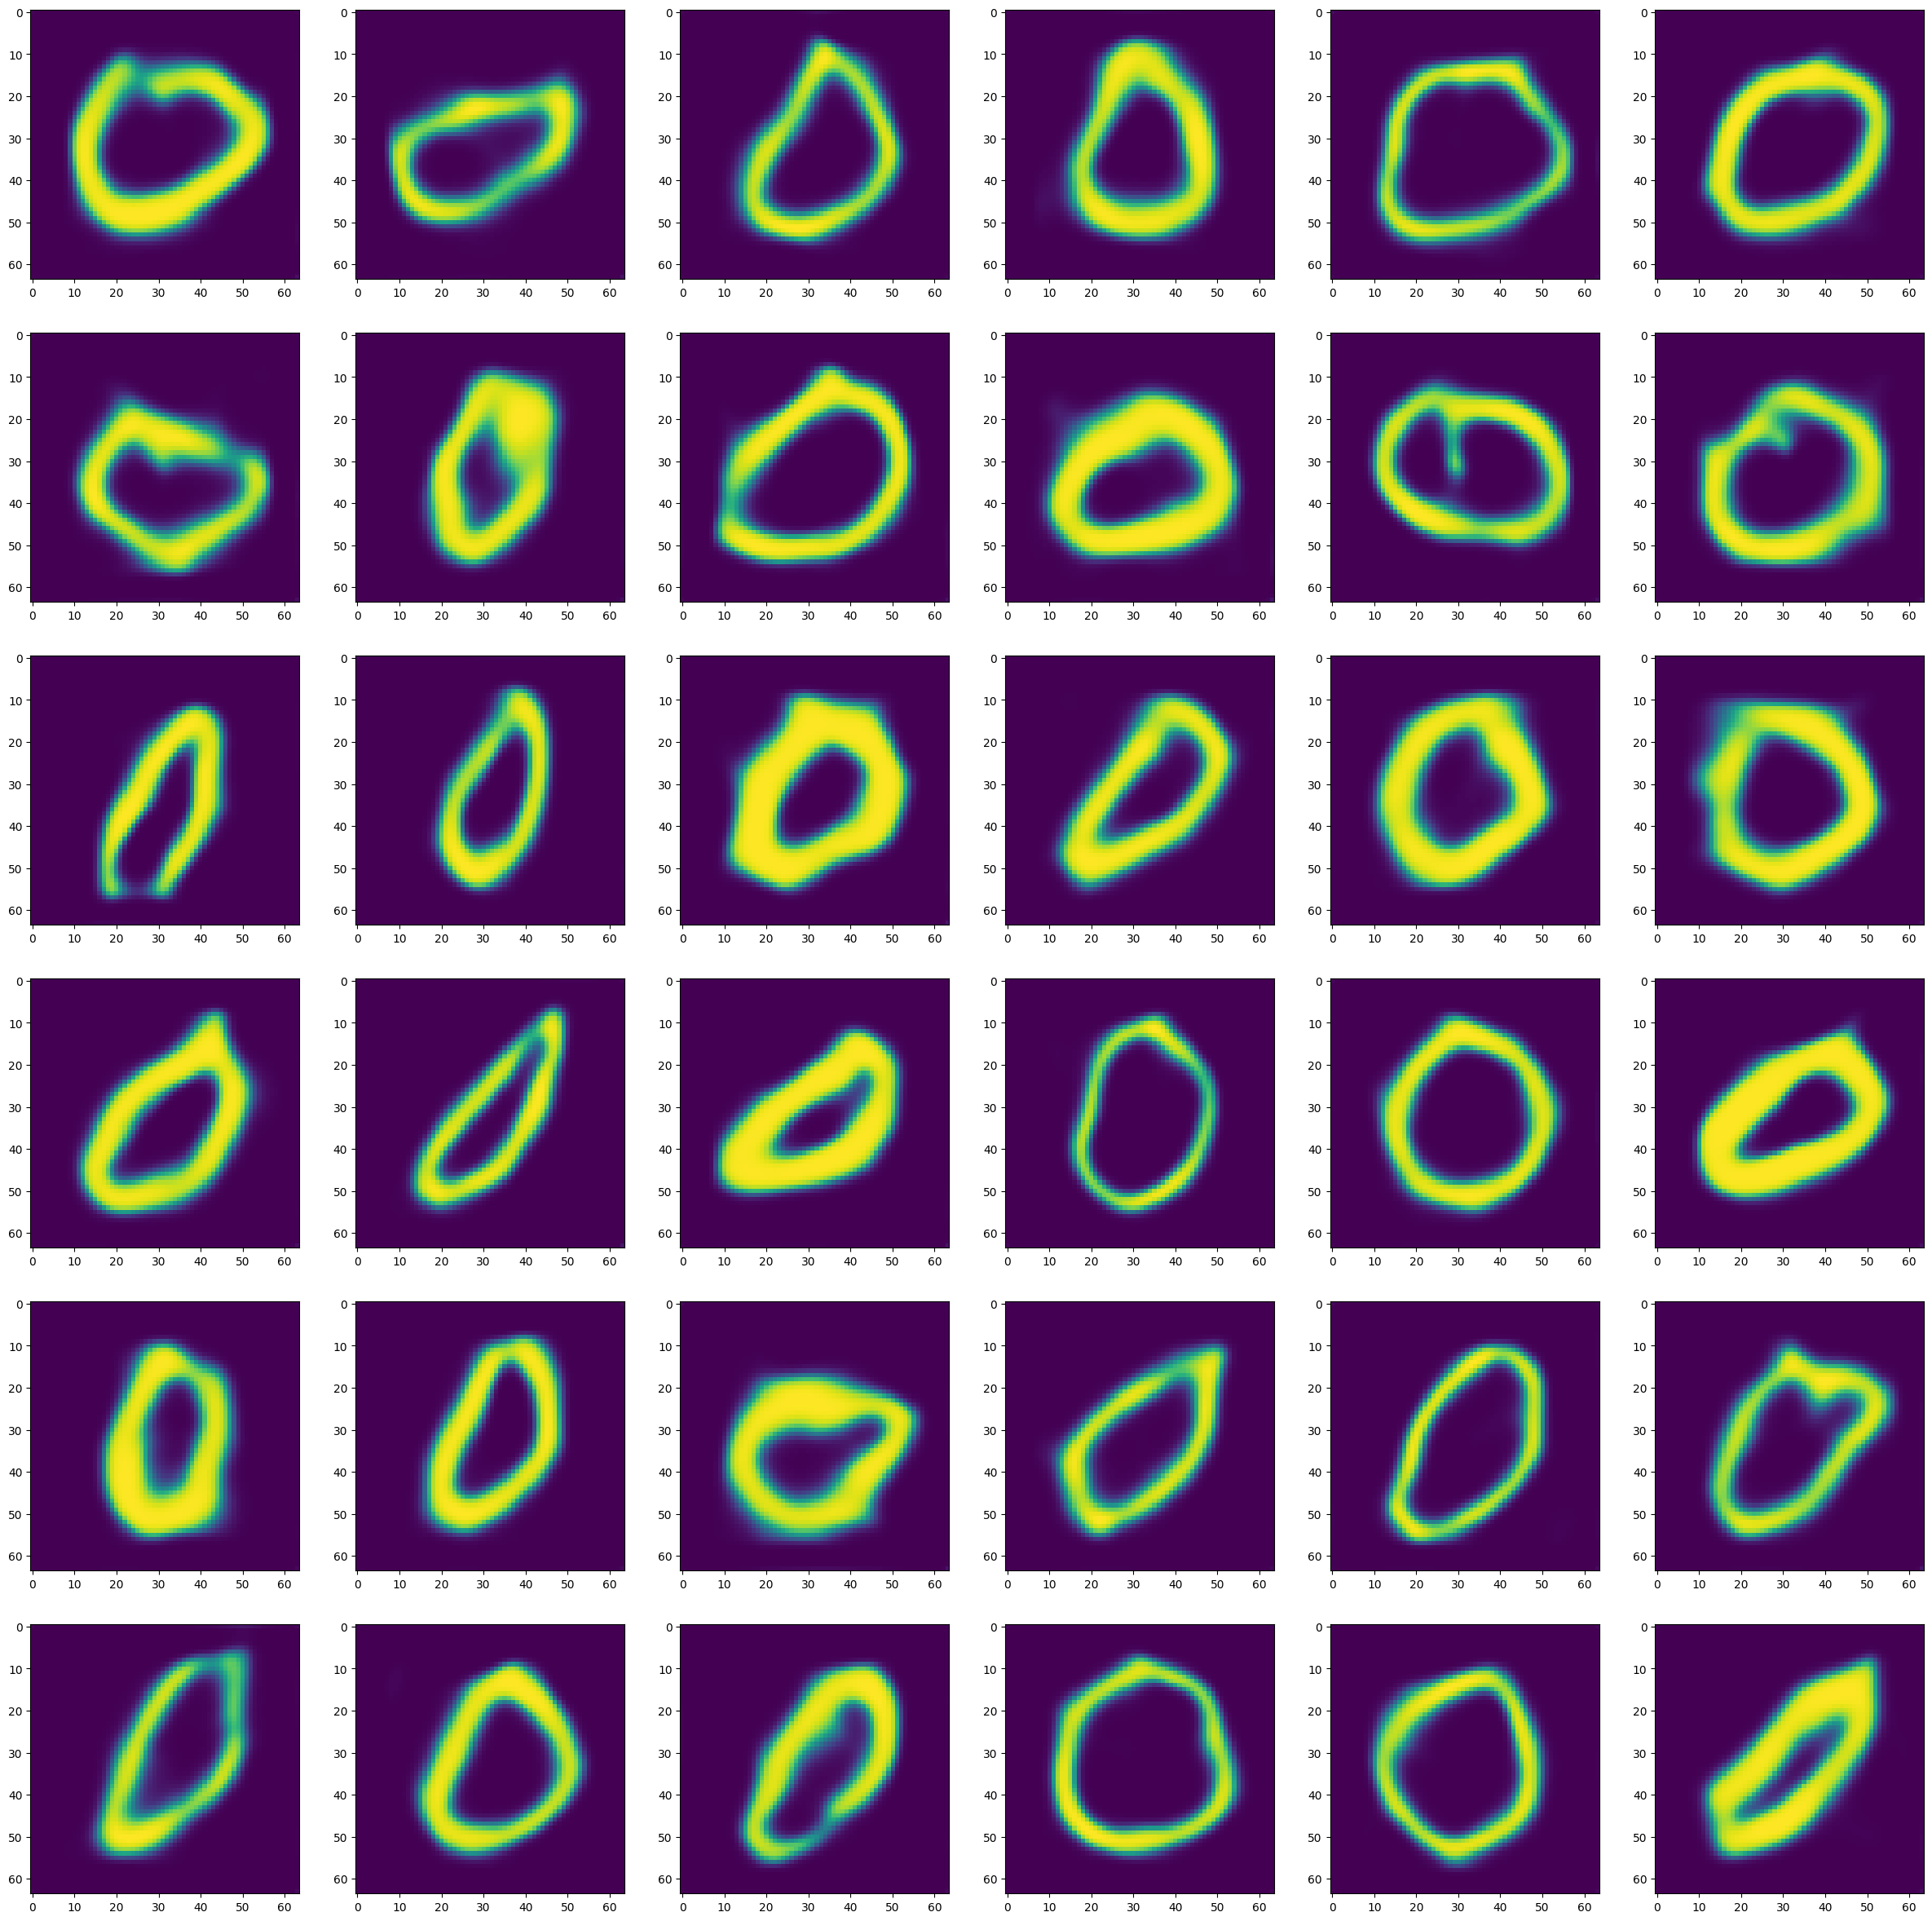

In [ ]:

z = torch.randn(50, Z_DIM, device=device)
fake_imgs = G(z)

plt.figure(figsize=(30, 30))
for ind, image in enumerate(fake_imgs):
    if ind >= 6*6: break
    plt.subplot(6, 6, ind+1)
    plt.imshow(((image.detach().cpu().numpy().squeeze() + 1) / 2))
plt.show()


# Генерация нескольких объектов

Выучим теперь весь датасет, а не только нули, а затем научим модель гененировать цифры по запросу.


In [ ]:
data_loader = DataLoader(mnist, batch_size=64)


In [ ]:
class SubMNIST(torch.utils.data.Dataset):
  def __init__(self, mnist):
    self.images = []
    self.sub = {0, 1, 2}
    for image, label in mnist:
      if label in self.sub:
        self.images.append(image)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    return self.images[index]

sub_mnist = SubMNIST(mnist)
dataloader = DataLoader(sub_mnist, batch_size, drop_last=True)


In [ ]:
D = Discriminator(channels=1).to(device)
G = Generator(Z_DIM, channels=1).to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
train(G, D, d_optimizer, g_optimizer, dataloader)

[D loss: ?] [G loss: ?]:   0%|          | 0/14500 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


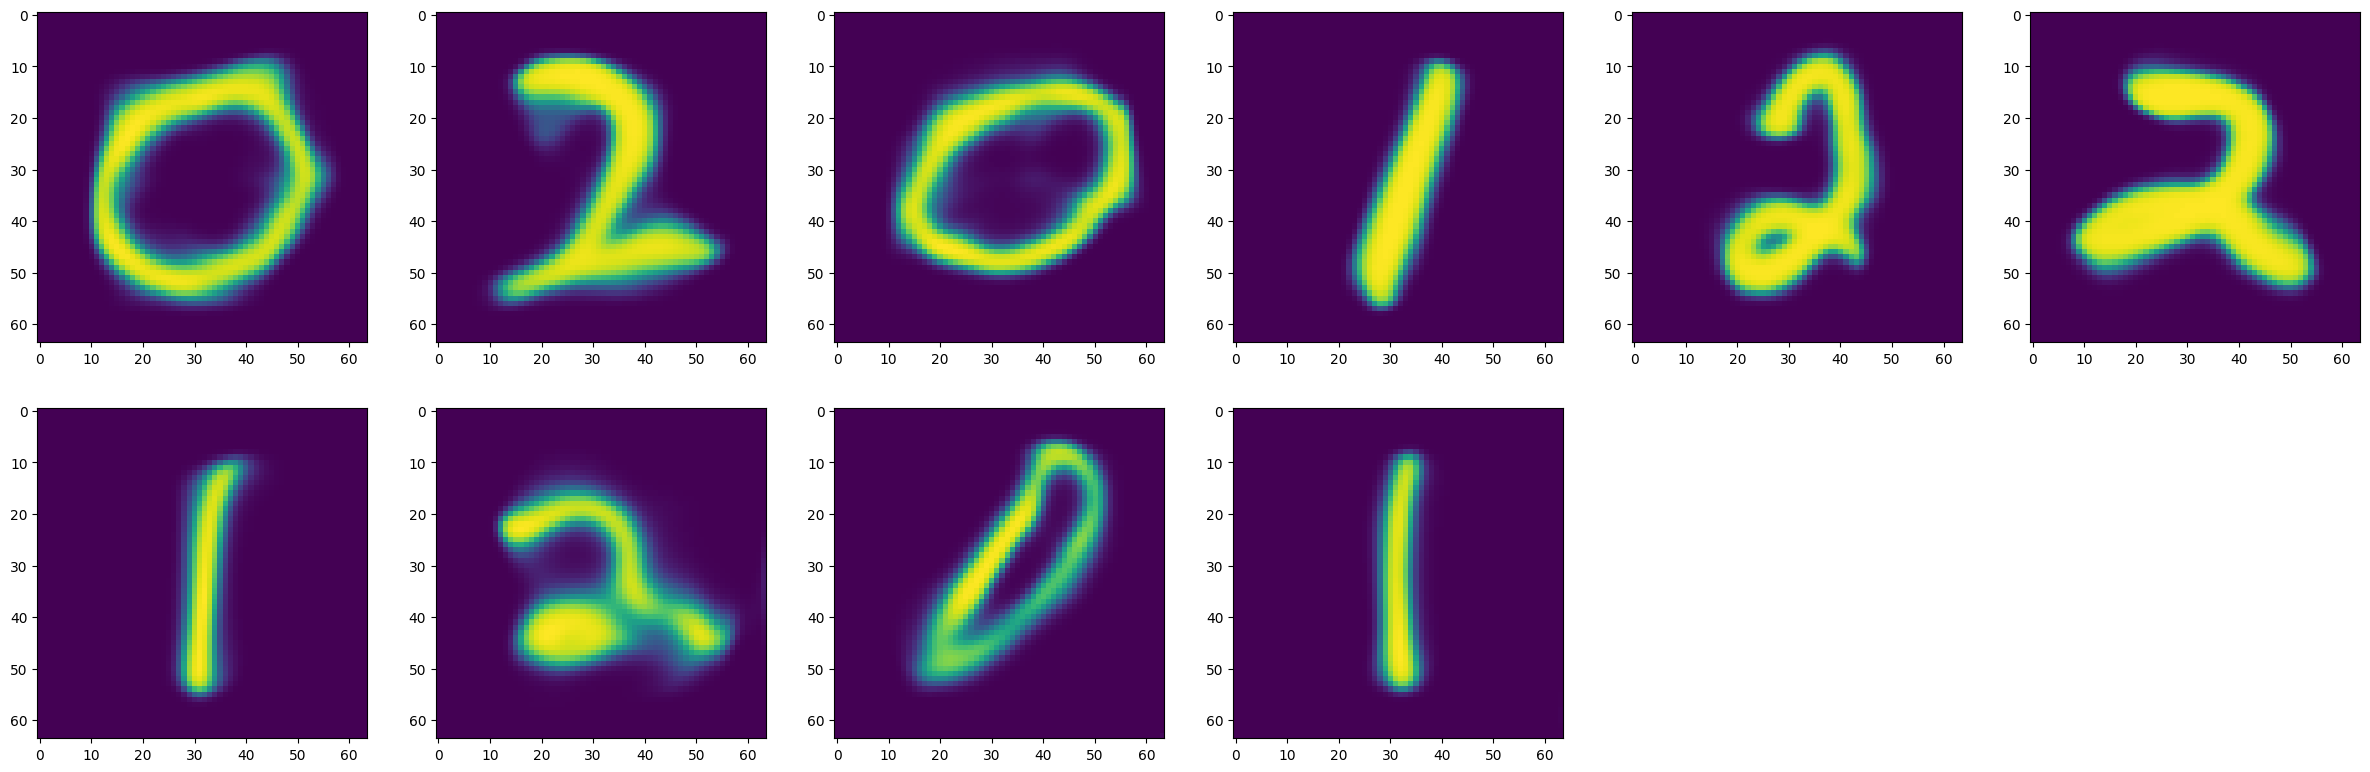

In [ ]:

z = torch.randn(10, Z_DIM, device=device)
fake_imgs = G(z)

plt.figure(figsize=(30, 30))
for ind, image in enumerate(fake_imgs):
    if ind >= 6*6: break
    plt.subplot(6, 6, ind+1)
    plt.imshow(((image.detach().cpu().numpy().squeeze() + 1) / 2))
plt.show()



# Генерация с условием (Conditional GAN)

In [ ]:
Z_DIM = 100
NUM_LABELS = 3
CHANNELS = 1
DIM_IMAGE = 64

In [ ]:
class Generator(nn.Module):

  def __init__(self, z_dim, num_labels, dim=64, channels=3):
    super().__init__()

    self.label_embedding = nn.Embedding(num_labels, embedding_dim=4 * 4)

    self.transform_noise = nn.Sequential(
        nn.Linear(z_dim, dim * 4* 4 * 4),
        nn.BatchNorm1d(dim * 4 * 4 * 4),
        nn.ReLU()
    )

    def upsample_block(in_channels, out_channels):
      return nn.Sequential(
          nn.Upsample(scale_factor=2, mode='bilinear'),
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU()
      )

    self.layers = nn.Sequential(
        upsample_block(in_channels=4*dim+1, out_channels=2*dim), # 2*dim x 8 x 8
        upsample_block(in_channels=2*dim, out_channels=dim), # dim x 16 x 16
        upsample_block(in_channels=dim, out_channels=dim), # dim x 32 x 32
        nn.Upsample(scale_factor=2, mode='bilinear'),
        nn.Conv2d(dim, channels, kernel_size=3, padding=1, stride=1), # channels x 64 x 64
        nn.Tanh() # [-1, 1]
    )


  def forward(self, x, labels):
    labels_emb = self.label_embedding(labels).view(-1, 1, 4, 4)
    y = self.transform_noise(x)
    y = y.view(y.shape[0], -1, 4, 4) # 256 x 4 x 4
    y = torch.cat([y, labels_emb], dim=1) # batch_size x 257 x 4 x 4

    return self.layers(y)

In [ ]:
class Discriminator(nn.Module):

  def __init__(self, num_labels, dim=64, channels=3):
    super().__init__()

    self.label_embedding = nn.Embedding(num_embeddings=num_labels, embedding_dim=64 * 64)

    def downsample_block(in_channels, out_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1),
          nn.InstanceNorm2d(out_channels),
          nn.LeakyReLU(0.2)
      )

    self.layers = nn.Sequential(
        downsample_block(in_channels=channels+1, out_channels=dim), # dim x 32 x 32
        downsample_block(in_channels=dim, out_channels=dim * 2), # dim * 2 x 16 x 16
        downsample_block(in_channels=dim * 2, out_channels=dim * 4), # dim * 4 x 8 x 8
        downsample_block(in_channels=dim * 4, out_channels=dim * 4), # dim * 4 x 4 x 4
        nn.Conv2d(in_channels=dim * 4, out_channels=1, kernel_size=4) # 1 x 1 x 1
    )


  def forward(self, x, labels):
    labels_emb = self.label_embedding(labels).view(-1, 1, 64, 64)

    x = torch.cat([x, labels_emb], dim=1) # channels + 1 x 64 x 64
    x = self.layers(x).view(-1)
    return x

In [ ]:
G = Generator(z_dim=Z_DIM, num_labels=NUM_LABELS, dim=DIM_IMAGE, channels=CHANNELS)
D = Discriminator(num_labels=NUM_LABELS, dim=DIM_IMAGE, channels=CHANNELS)


In [ ]:
def compute_gradient_penalty(D, real_images, fake_images, labels):
  """Calculates the gradient penalty loss for WGAN GP"""
  alpha = torch.rand((real_images.size(0), 1, 1, 1), device=device)
  # Get random interpolation between real and fake samples
  interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)
  d_interpolates = D(interpolates, labels)
    # Get gradient w.r.t. interpolates
  gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(real_images.shape[0], requires_grad=False, device=device), # gradients w.t. output. 1 is default
        create_graph=True,
        retain_graph=True, # keep all gradients for further optimization steps
        only_inputs=True,
  )[0]
  gradients = gradients.view(gradients.size(0), -1)
  gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
  return gradient_penalty

In [ ]:
NUM_EPOCHS = 50
N_CRITIC = 5
LAMBDA_GP = 10
Z_DIM = 100


def train(G, D, d_optimizer, g_optimizer, dataloader):
    with tqdm(total=NUM_EPOCHS*len(dataloader), desc=f"[D loss: ?] [G loss: ?]") as pbar:
        for epoch in range(NUM_EPOCHS):
            print(epoch)
            for i, (imgs, labels) in enumerate(dataloader):
                real_labels = labels.to(device)
                real_imgs = imgs.to(device)
                d_optimizer.zero_grad()

                # sample noise
                z = torch.randn(imgs.shape[0], Z_DIM, device=device)

                fake_imgs = G(z, real_labels)

                real_valid = D(real_imgs, real_labels)
                fake_valid = D(fake_imgs, real_labels)
                gradient_penalty = compute_gradient_penalty(D, real_imgs, fake_imgs, real_labels)
                d_loss = -torch.mean(real_valid) + torch.mean(fake_valid) + LAMBDA_GP * gradient_penalty
                d_loss.backward()
                d_optimizer.step()

                # every N_CRITIC epochs train the G
                if i % N_CRITIC == 0 :
                    fake_imgs = G(z, real_labels)
                    fake_valid = D(fake_imgs, real_labels)

                    g_optimizer.zero_grad()
                    g_loss = -torch.mean(fake_valid)

                    g_loss.backward()
                    g_optimizer.step()

                pbar.set_description(f"[D loss: {d_loss.item():.2f}] [G loss: {g_loss.item():.2f}]")
                pbar.update(1)





In [ ]:
G = Generator(z_dim=Z_DIM, num_labels=NUM_LABELS, dim=DIM_IMAGE, channels=CHANNELS).to(device)
D = Discriminator(num_labels=NUM_LABELS, dim=DIM_IMAGE, channels=CHANNELS).to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
class SubMNIST(torch.utils.data.Dataset):
  def __init__(self, mnist):
    self.images = []
    self.sub = {0, 1, 2}
    for image, label in mnist:
      if label in self.sub:
        self.images.append((image, label))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    return self.images[index]

sub_mnist = SubMNIST(mnist)
dataloader = DataLoader(sub_mnist, batch_size, drop_last=True)

In [ ]:
train(G, D, d_optimizer, g_optimizer, dataloader)

[D loss: ?] [G loss: ?]:   0%|          | 0/14500 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
torch.save(G.state_dict(), 'G.pth')

In [ ]:
torch.save(D.state_dict(), 'D.pth')

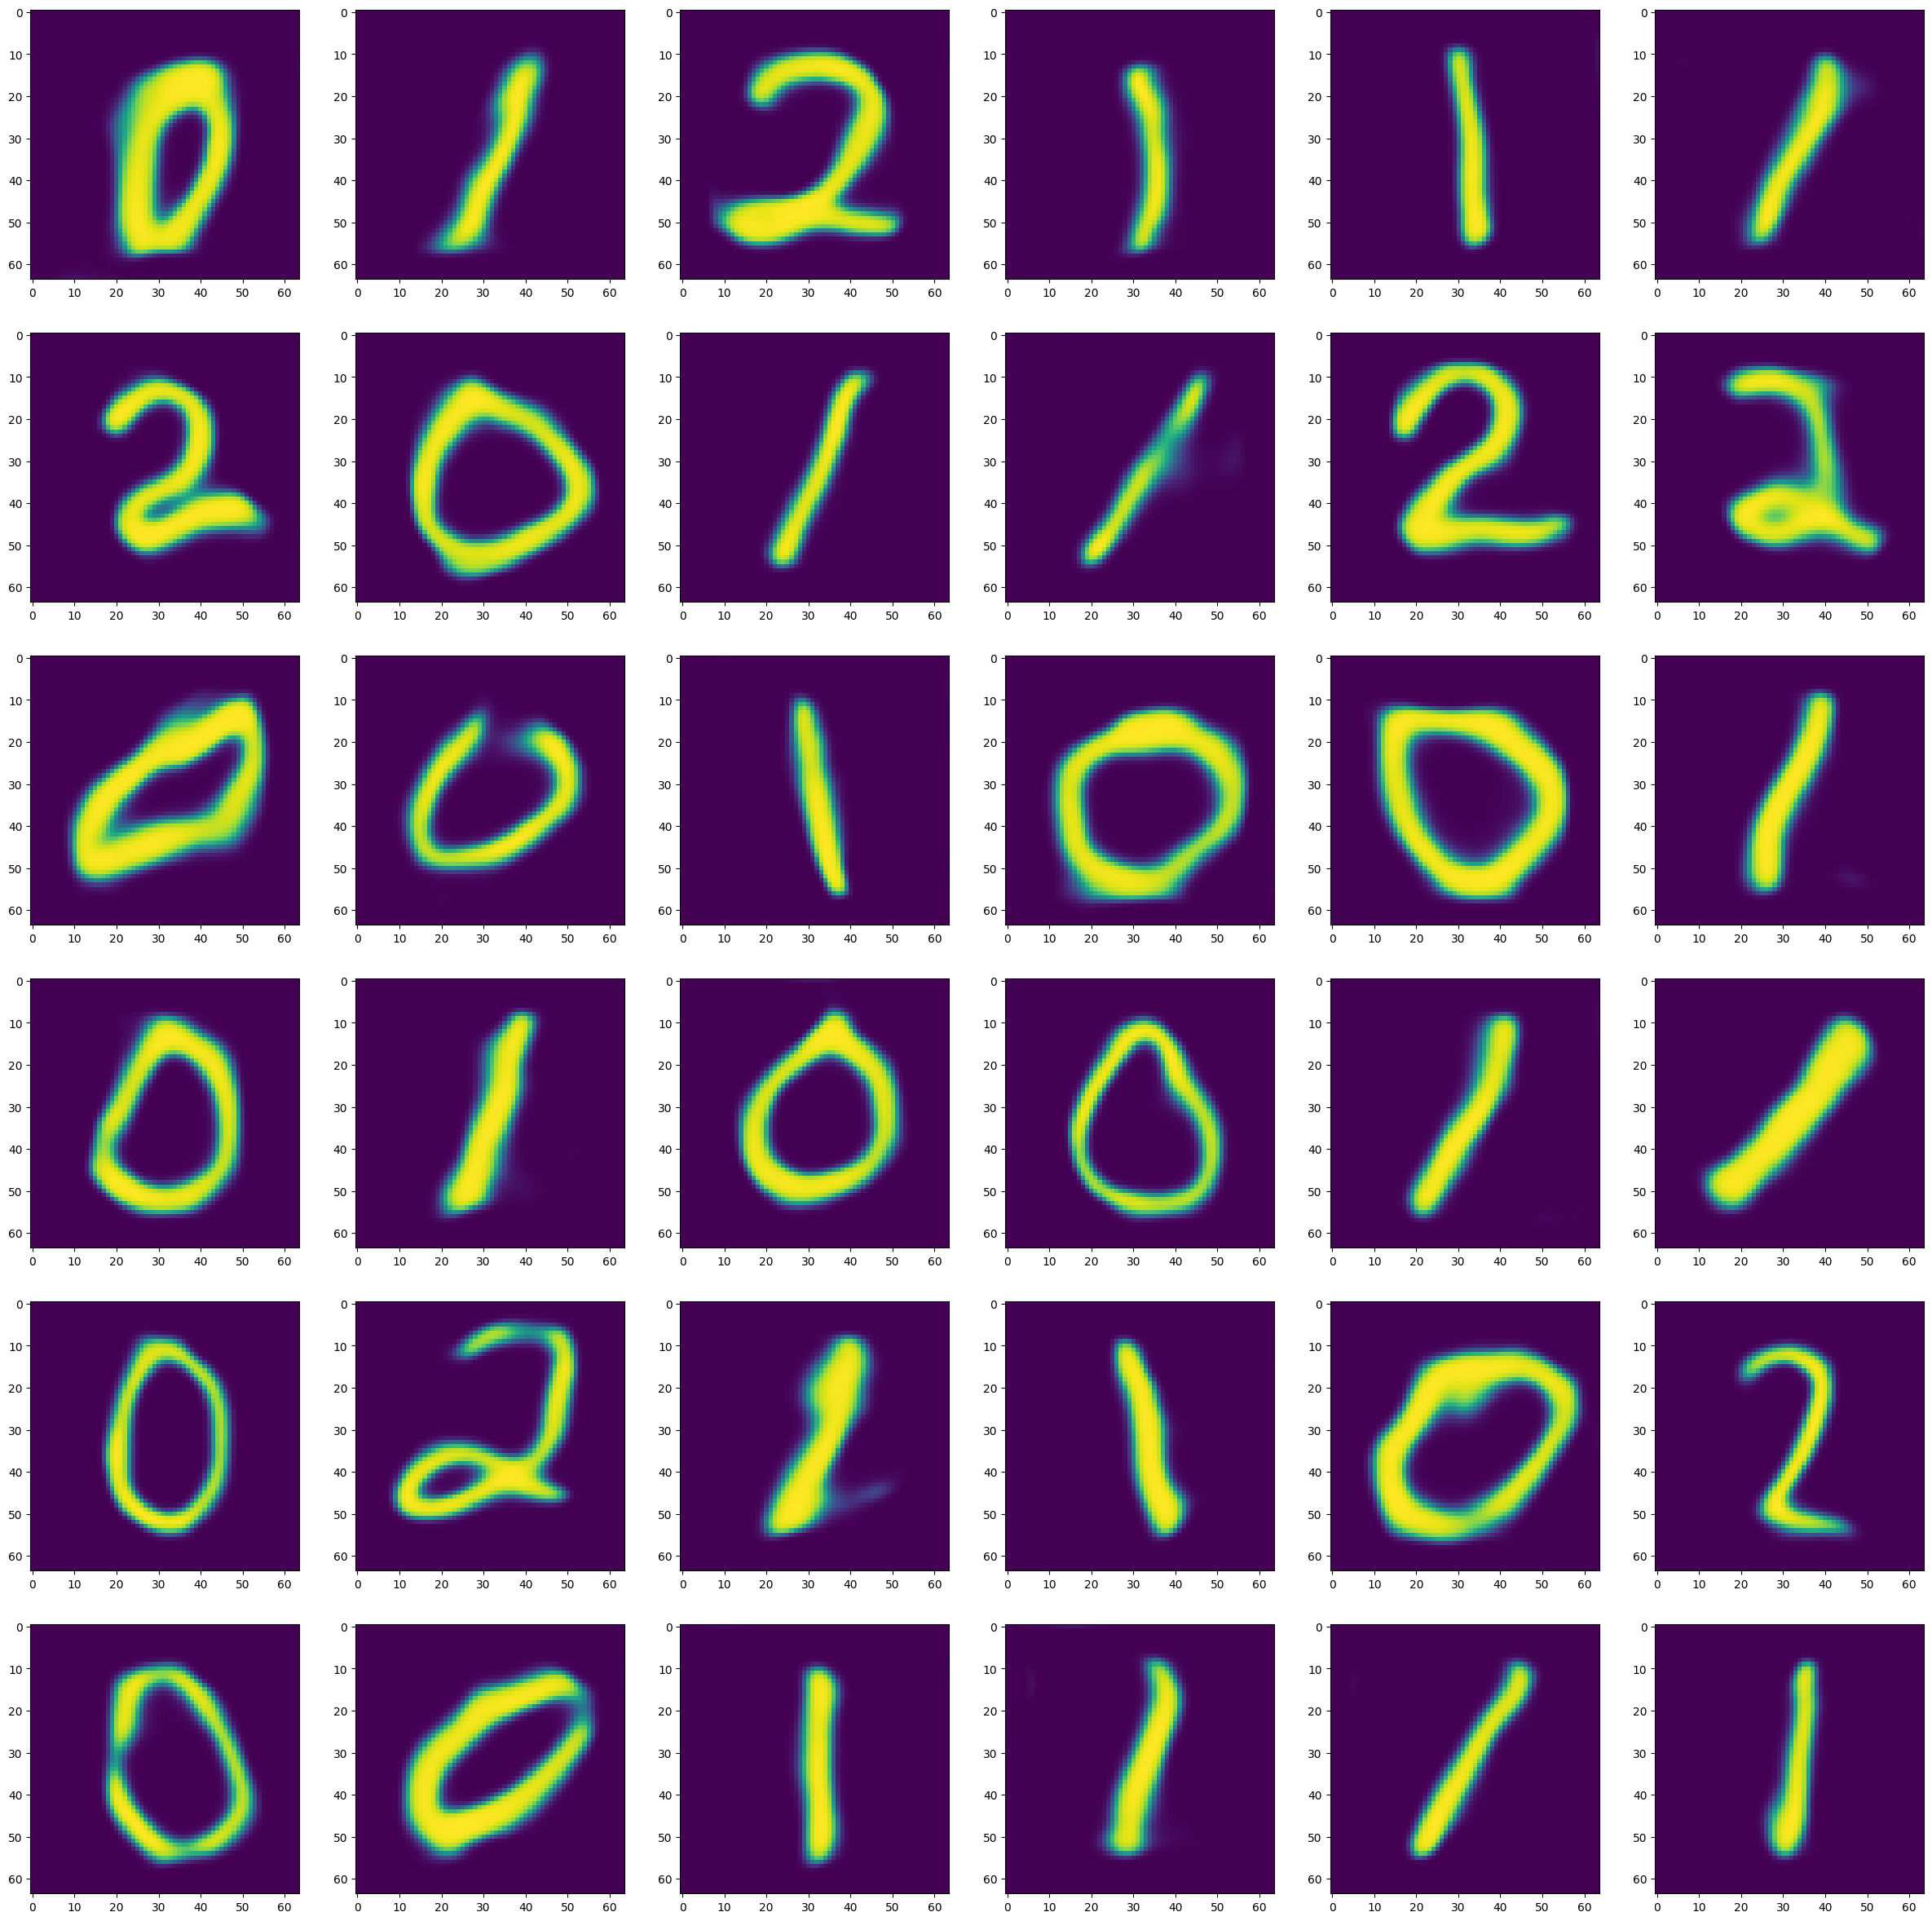

In [ ]:
for i, (imgs, labels) in enumerate(dataloader):
  imgs = imgs.to(device)
  labels = labels.to(device)
  z = torch.randn(imgs.shape[0], Z_DIM, device=device)
  generated = G(z, labels).to('cpu')
  plt.figure(figsize=(30, 30))
  for ind, image in enumerate(generated):
      if ind >= 36: break
      plt.subplot(6, 6, ind+1)
      plt.imshow(((image.detach().cpu().numpy().squeeze() + 1) / 2))
  plt.show()
  break

In [ ]:
labels.shape

torch.Size([64])

In [ ]:
f = torch.tensor([0, 1]).to(device)

In [ ]:
f.shape

torch.Size([2])

In [ ]:
f = torch.tensor([2, 2]).to(device)
z = torch.randn(2, Z_DIM, device=device)
generated = G(z, f).to('cpu')

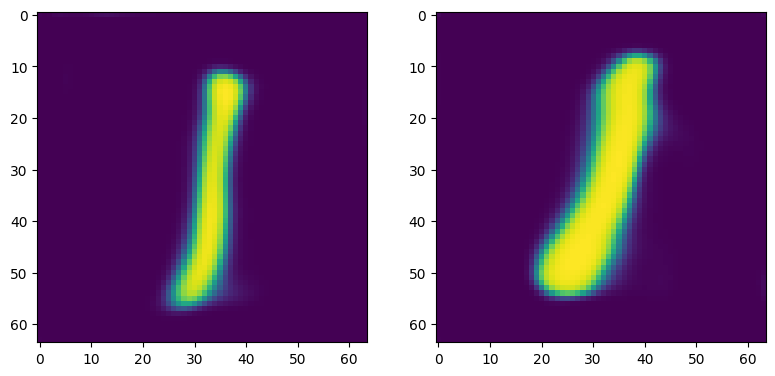

In [ ]:
f = torch.tensor([1, 1]).to(device)
z = torch.randn(2, Z_DIM, device=device)
generated = G(z, f).to('cpu')

plt.figure(figsize=(30, 30))
for ind, image in enumerate(generated):
    if ind >= 36: break
    plt.subplot(6, 6, ind+1)
    plt.imshow(((image.detach().cpu().numpy().squeeze() + 1) / 2))
plt.show()

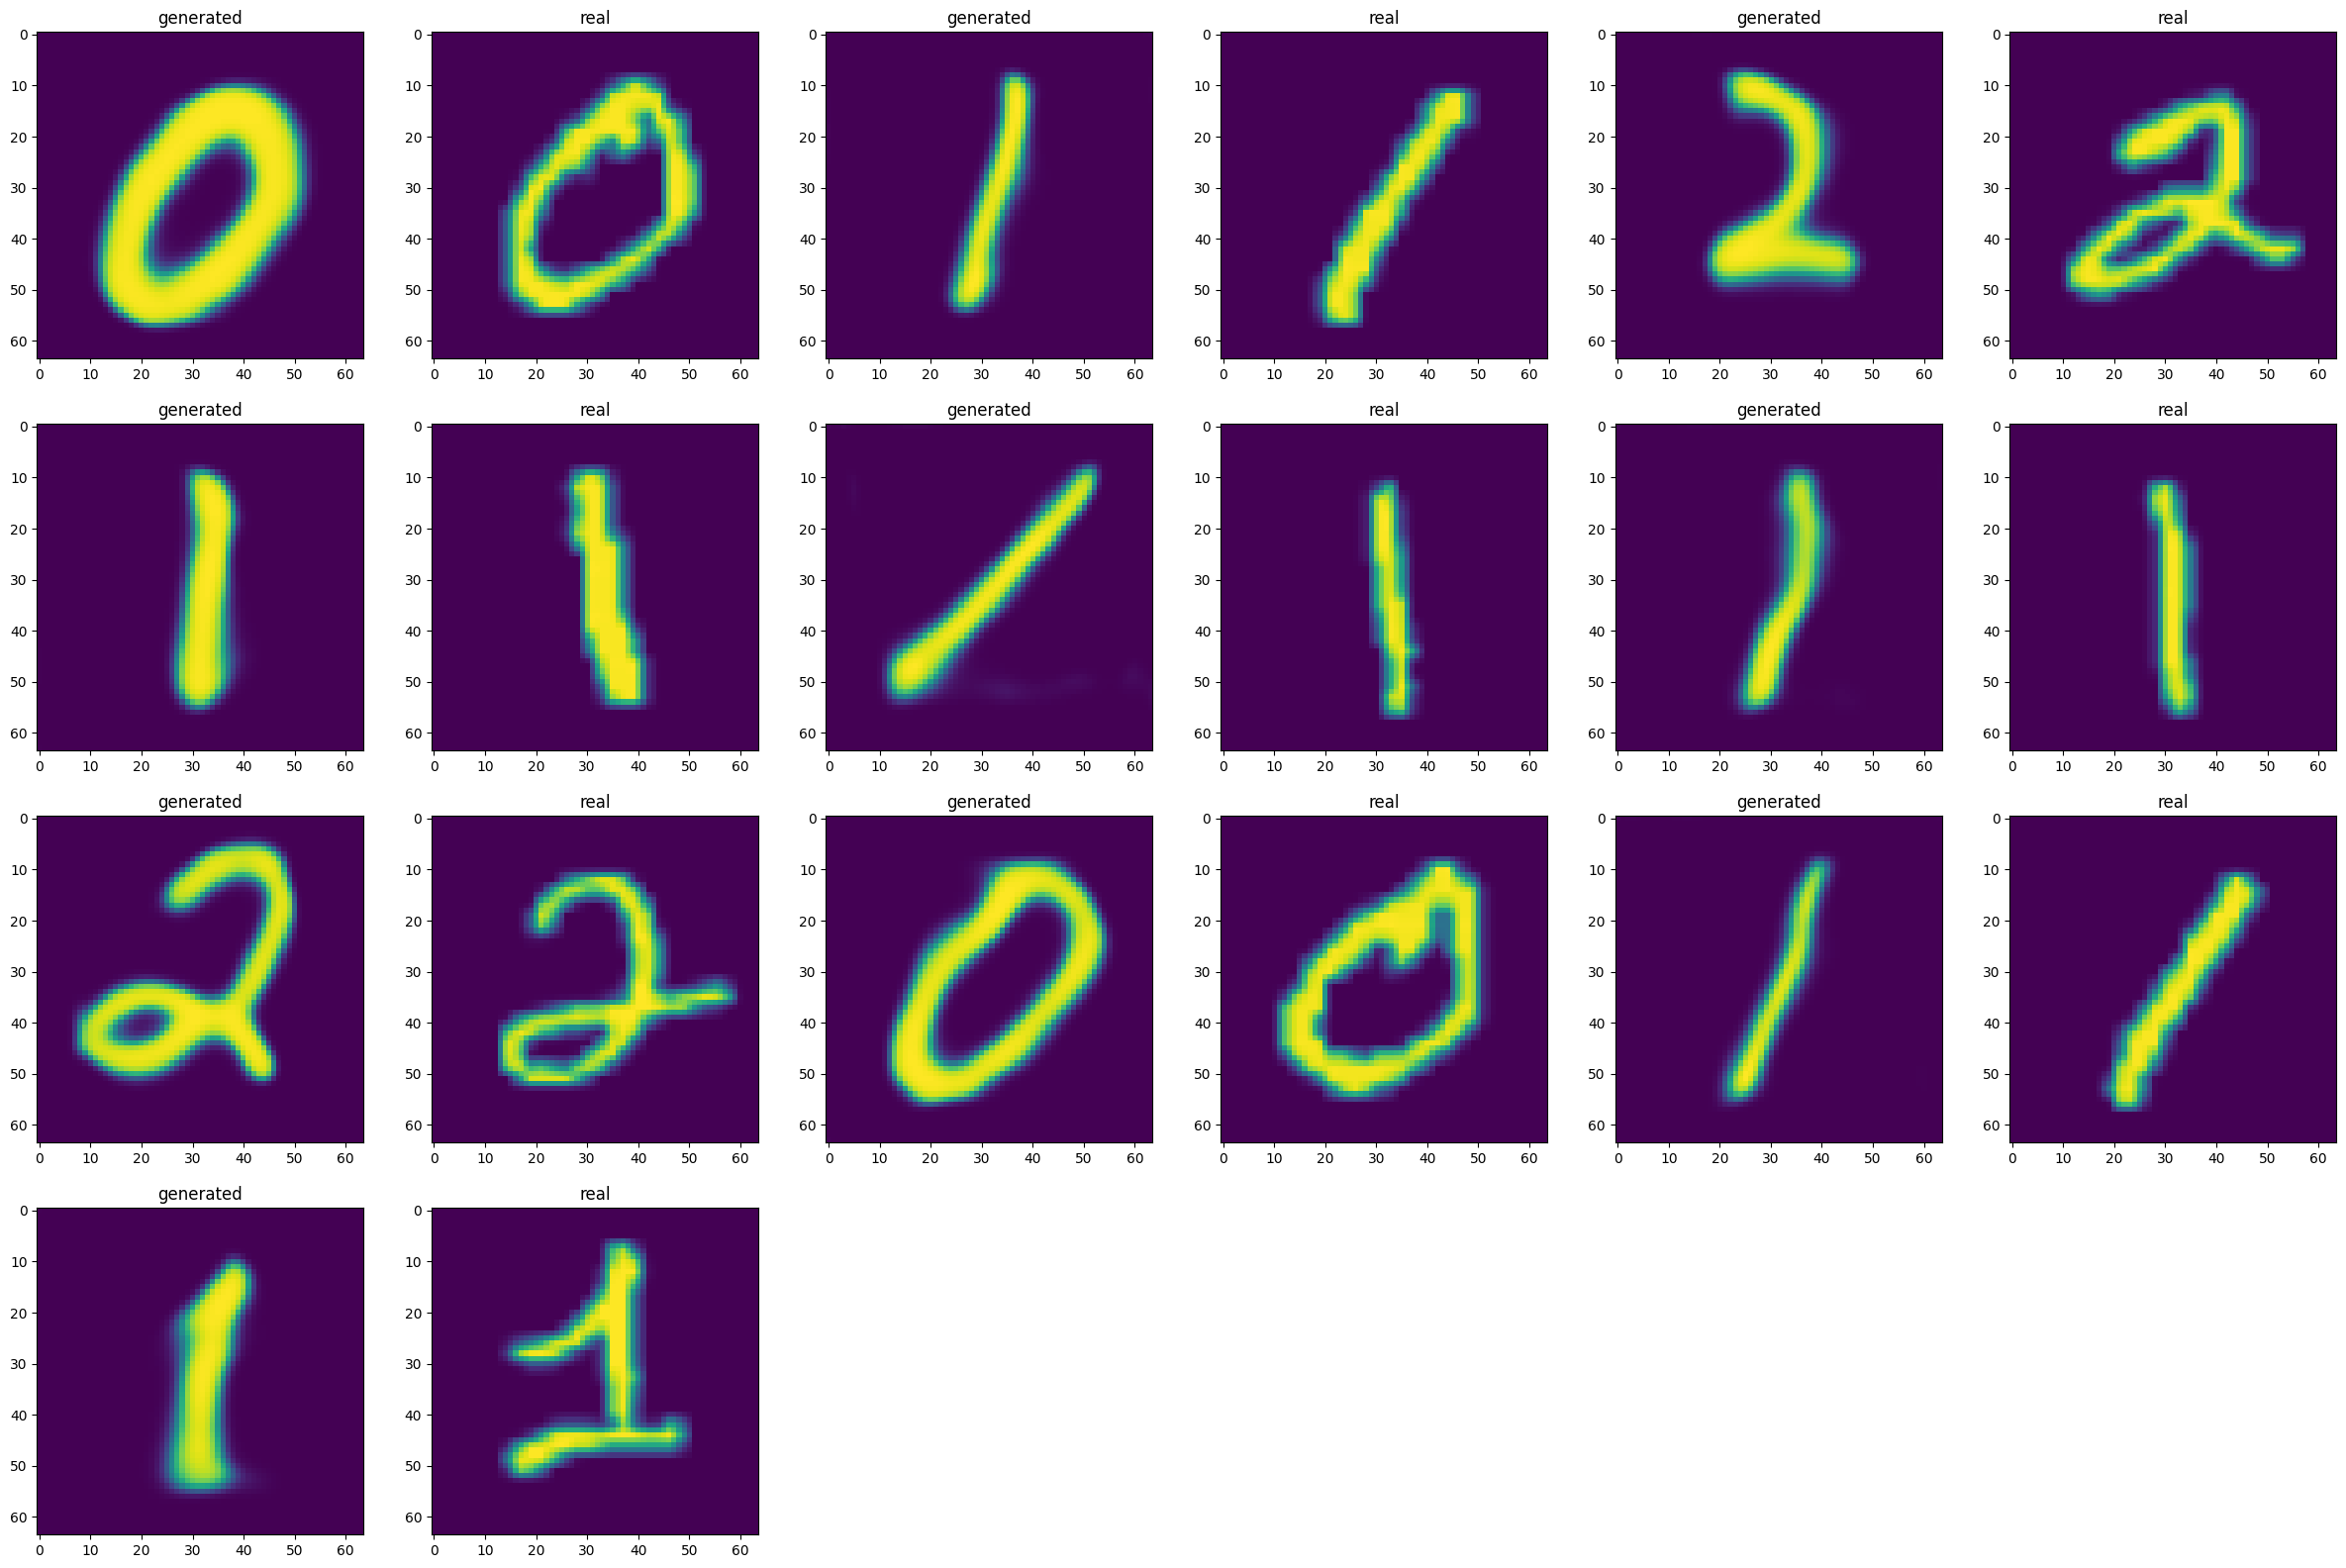

In [ ]:
# сравнить с реальными сэмплами

for i, (imgs, labels) in enumerate(dataloader):
  imgs = imgs.to(device)
  labels = labels.to(device)
  z = torch.randn(imgs.shape[0], Z_DIM, device=device)
  generated = G(z, labels).to('cpu')
  plt.figure(figsize=(30, 30))
  for ind, image in enumerate(generated):
      if ind >= 10: break
      plt.subplot(6, 6, 2*ind+1)
      plt.title('generated')
      plt.imshow(((image.detach().cpu().numpy().squeeze() + 1) / 2))
      plt.subplot(6, 6, 2*ind + 2)
      plt.title('real')
      plt.imshow(((imgs[ind].detach().cpu().numpy().squeeze() + 1) / 2))

  plt.show()

  break